In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ipyleaflet
from ipyleaflet import Map
from sklearn.metrics import mean_squared_log_error
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/train.csv')

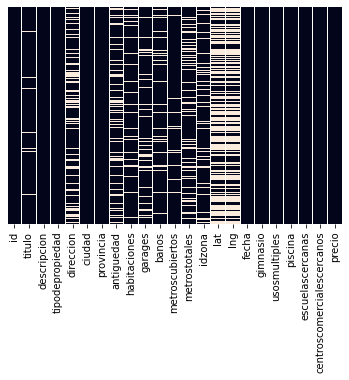

In [3]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False)

# varias de las columnas que podrían ser interesantes como features cuentan con null values

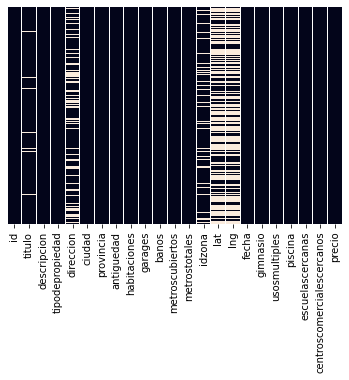

In [4]:
# queda la media en esas columnas

quantity_columns = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales']

for col in quantity_columns:
    df[col] = df[col].fillna(df[col].mean())

sns.heatmap(df.isna(), yticklabels=False, cbar=False)

In [5]:
# si quisieramos hacer algo con las lat y lng, podríamos utilzar las direcciones + ipyleaflet para inferir los na values

# Análisis

In [6]:
# df.info()
# df['tipodepropiedad'].value_counts()
# df['provincia'].value_counts()
df['ciudad'].value_counts()

Querétaro                        12646
Benito Juárez                    11014
Zapopan                          10360
San Luis Potosí                   7925
Mérida                            7162
Monterrey                         6946
Alvaro Obregón                    6633
Cuauhtémoc                        6614
Naucalpan de Juárez               6554
Miguel Hidalgo                    5795
Atizapán de Zaragoza              5783
Tlalpan                           5721
Huixquilucan                      5718
Coyoacán                          5293
Puebla                            4636
Guadalajara                       4006
San Andrés Cholula                3805
Cancún                            3779
Cuernavaca                        3775
Chihuahua                         3757
Tlalnepantla de Baz               3588
Cuautitlán Izcalli                3408
Tlajomulco de Zúñiga              3254
Gustavo A. Madero                 3141
Iztapalapa                        3093
Cuajimalpa de Morelos    

In [7]:
# heatmap de precios de propiedades

def prices_in_map(df):

    # filtro de lat y lng muy alejadas
    q_lat=df["lat"].quantile(0.90)
    q_lng=df["lng"].quantile(0.90)
    df=df[(df['lat'] < q_lat) & (df['lng'] < q_lng)]

    args=[]

    for index, row in df.iterrows():
        args.append([row['lat'], row['lng'], row['precio'] / 100])
        
    heatmap=ipyleaflet.Map(center=(q_lat, q_lng), zoom=4)

    heatmap_layer=ipyleaflet.Heatmap(locations=args, radius=10, blur=20)

    heatmap.add_layer(heatmap_layer)

    display(heatmap)

Text(0.5, 0, 'Provincia')

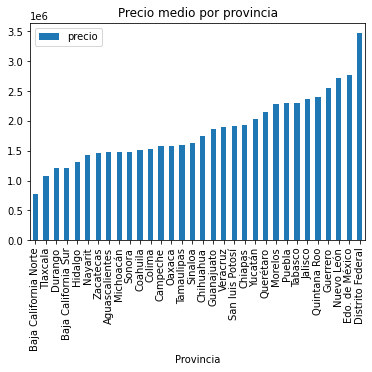

In [8]:
# precio medio por provincia

df_provinces = df.groupby(['provincia']).mean().sort_values(by = 'precio')
ax = df_provinces.plot.bar(y = 'precio')
ax.set_title('Precio medio por provincia')
ax.set_xlabel('Provincia')

Text(0.5, 0, 'Ciudad')

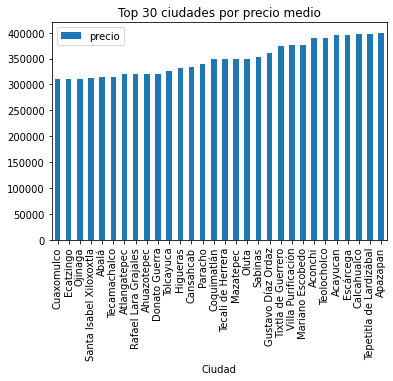

In [9]:
# precio medio por ciudad

top_cities = 30

df_cities = df.groupby(['ciudad']).mean().sort_values(by = 'precio')
ax = df_cities.head(top_cities).plot.bar(y = 'precio')
ax.set_title(f'Top {top_cities} ciudades por precio medio')
ax.set_xlabel('Ciudad')

In [10]:
# distribución en el mapa de las ciudades
# a diferencia del norte, hacia el sur hay oferta
# las propiedades más caras parecen estar en el centro del país

prices_in_map(df_cities)

Map(center=[25.439861593685706, -92.68436530305485], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Text(0.5, 0, 'Años')

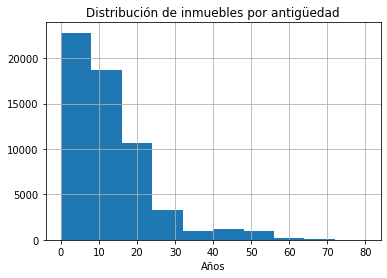

In [11]:
# ¿cuál es la relación entre la antiguedad y el precio en el distrito más costoso?

df_df = df[df['provincia'] == 'Distrito Federal']

ax = df_df['antiguedad'].hist()

ax.set_title('Distribución de inmuebles por antigüedad')
ax.set_xlabel('Años')

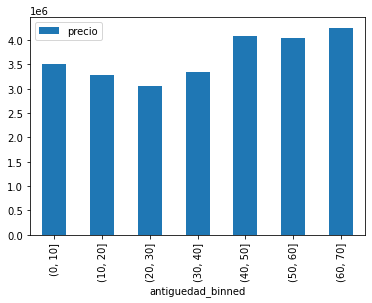

In [12]:
# como contamos con un amplio rango de antiüedad para los inmuebles, miramos sus precios promediados en tramos de 10 años

ranges = range(int(df_df['antiguedad'].min()), int(df_df['antiguedad'].max()), 10)

df_df['antiguedad_binned'] = pd.cut(df_df['antiguedad'], ranges)

df_df.groupby('antiguedad_binned').mean().plot.bar(y='precio')

# no nos dice mucho, son casi todos iguales, tal vez sea mejor segmentar por otras características

Text(0.5, 0, 'Cantidad de habitaciones')

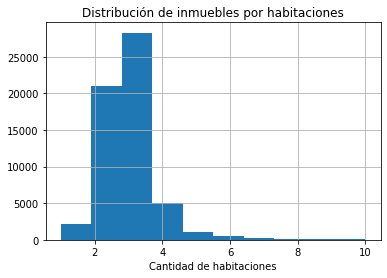

In [13]:
# probamos con por ejemplo la cantidad de habitaciones en lugar de la antiguedad

ax = df_df['habitaciones'].hist()

ax.set_title('Distribución de inmuebles por habitaciones')
ax.set_xlabel('Cantidad de habitaciones')

Text(0.5, 0, 'Cantidad de habitaciones')

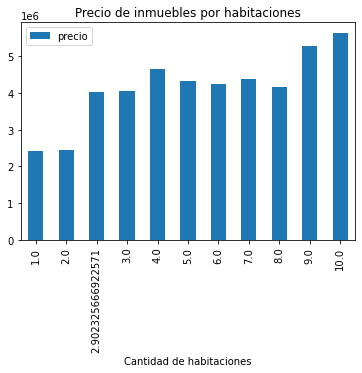

In [14]:
ax = df_df.groupby('habitaciones').mean().plot.bar(y='precio')
ax.set_title('Precio de inmuebles por habitaciones')
ax.set_xlabel('Cantidad de habitaciones')

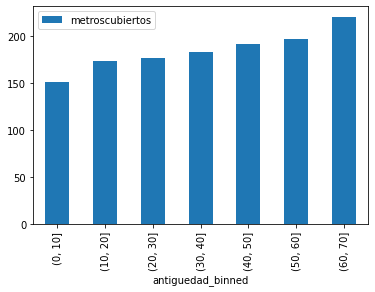

In [15]:
# ¿hay alguna relación entre que tan grande es la propiedad y la antiguedad?

df_df.groupby('antiguedad_binned').mean().plot.bar(y='metroscubiertos')

# claramente, más antiguos, más metros cubiertos

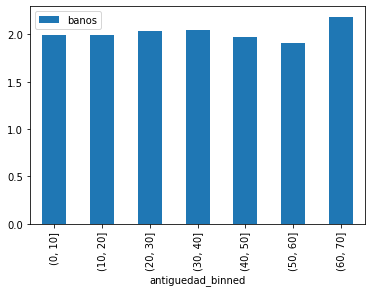

In [16]:
# ¿y la cantidad de baños respecto de la antiguedad?

df_df.groupby('antiguedad_binned').mean().plot.bar(y='banos')

# en general, hay dos baños, por lo que mirar los baños por antigüedad no nos dice mucho

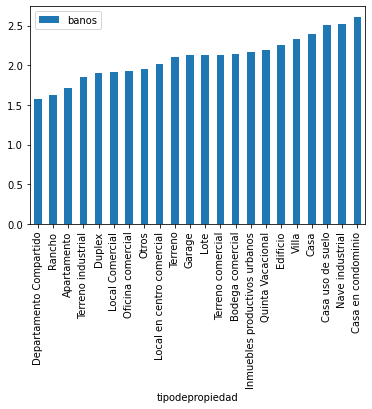

In [17]:
# ¿si miramos los baños por tipo de propiedad?

df_df.groupby('tipodepropiedad').mean().sort_values(by='banos').plot.bar(y='banos')

# dependiendo del tipo de propiedad, se pueden ver más baños o no

### Prueba de concepto

In [18]:
# regresor que usa lstsq
# habría que implementar esto en c++

class TpRegressor:
    def __init__(self, fns):
        self.fns = fns

    def apply_column_wise(self, P):
        assert(P.shape[1] == len(self.fns))
        for i in range(P.shape[1]):
            P[:,i] = self.fns[i](P[:,i])
        return P

    def fit(self, A, b):
        assert(A.shape[0] == b.shape[0])
        self.A = self.apply_column_wise(A)
        self.b = b
        self.coefs = np.linalg.lstsq(self.A, self.b)[0]

    def predict(self, X):
        return self.apply_column_wise(X) @ self.coefs


In [19]:
def train_and_predict(train_df, test_df, features_fns, title=""):

    fns = list(features_fns.values())
    features = list(features_fns.keys())

    target_feature = 'precio'

    # definición del regresor
    regressor = TpRegressor(fns)

    # train
    A = train_df[features].values
    b = train_df[target_feature].values

    regressor.fit(A, b)

    # predict & plot
    y_test = test_df[target_feature].values
    y_pred = regressor.predict(test_df[features].values)

    if title != "":
        plt.scatter(test_df.id.values, y_test)
        plt.scatter(test_df.id.values, y_pred)
        plt.title(title)
        plt.xlabel('id propiedad')
        plt.ylabel('precio')
        plt.plot()
        plt.show()
    return mean_squared_log_error(y_test, y_pred)

def train_and_predict_suit(train_df, test_df, all_features_fns):
    features_fns = {}
    errors = []

    for k, v in all_features_fns.items():
        features_fns[k] = v

        # descomentar para ver el progreso al agregar features
        error = train_and_predict(train_df, test_df, features_fns, f'+feature "{k}"')
#         error = train_and_predict(train_df, test_df, features_fns)

        errors.append(error)

    all_features = list(all_features_fns.keys())

    plt.title("errores de las pruebas mostradas (RMLSE) a medida que se agregan features")
    plt.xlabel("cantidad de features")
    plt.ylabel("error")
    plt.xticks(np.arange(len(all_features)), all_features)
    plt.plot(errors)

train_df (1903, 23)
test_df (476, 23)


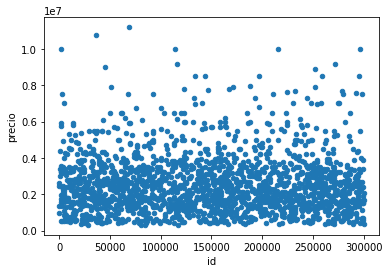

In [20]:
# selección de grupo para hacer la prueba

selection_df = df[
    (df['ciudad'] == 'Querétaro') &
    (df['tipodepropiedad'] == 'Casa')
].dropna()

limit = math.floor(selection_df.shape[0] * .8)

train_df = selection_df[:limit]
test_df = selection_df[limit:]

train_df.plot.scatter(x='id', y='precio')

print(f"train_df {train_df.shape}")
print(f"test_df {test_df.shape}")

# fn custom vectorizadas

np_x = np.vectorize(lambda n: n)
np_x2 = np.vectorize(lambda n: n ** 2)
np_x3 = np.vectorize(lambda n: n ** 3)
np_x4 = np.vectorize(lambda n: n ** 4)


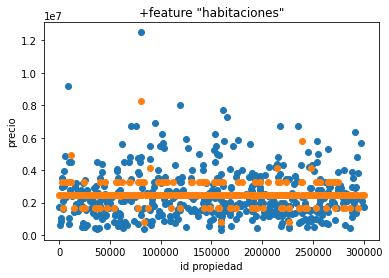

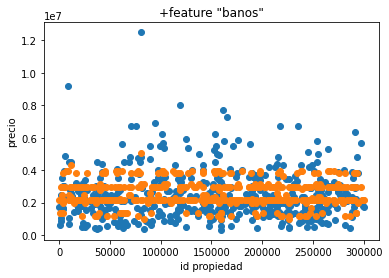

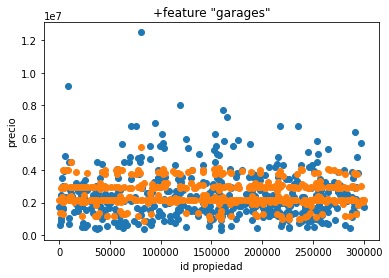

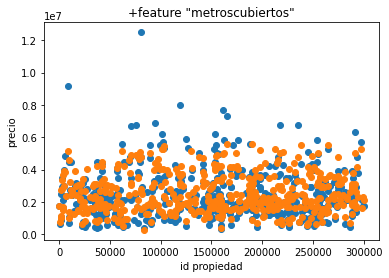

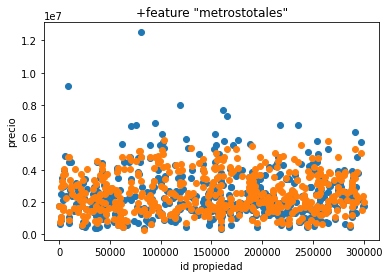

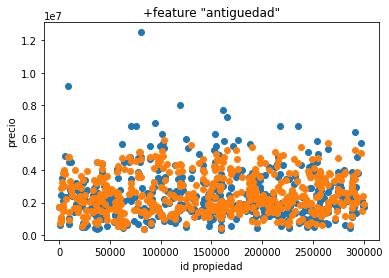

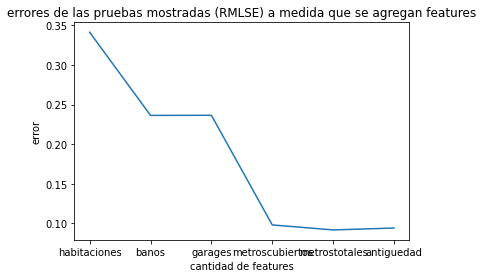

In [21]:
all_features_fns = {
    'habitaciones': np_x,
    'banos': np_x,
    'garages': np_x,
    'metroscubiertos': np_x,
    'metrostotales': np_x,
    'antiguedad': np_x,
}

train_and_predict_suit(train_df, test_df, all_features_fns)

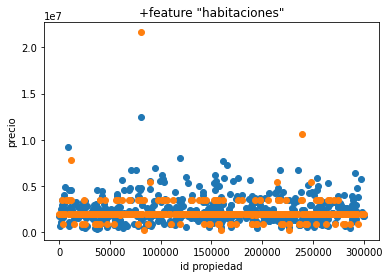

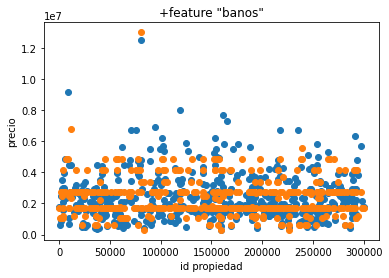

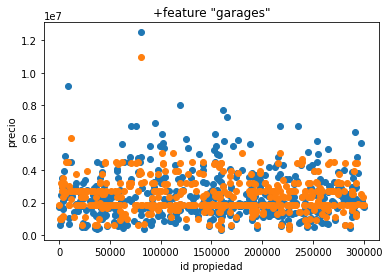

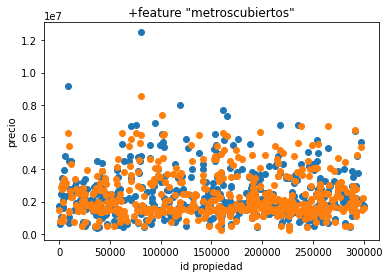

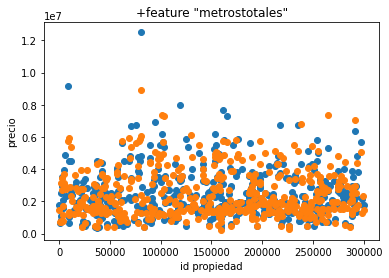

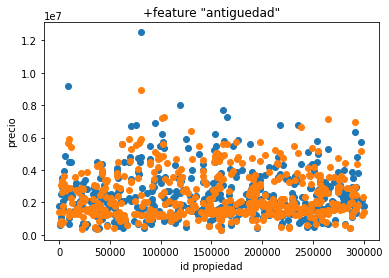

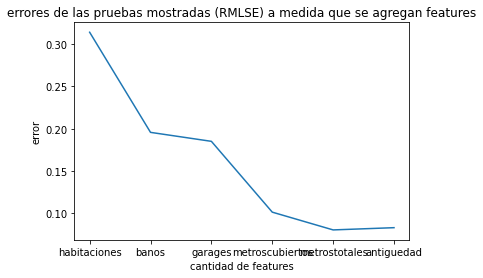

In [22]:
all_features_fns = {
    'habitaciones': np_x2,
    'banos': np_x2,
    'garages': np_x2,
    'metroscubiertos': np_x3,
    'metrostotales': np_x2,
    'antiguedad': np_x,
}

train_and_predict_suit(train_df, test_df, all_features_fns)

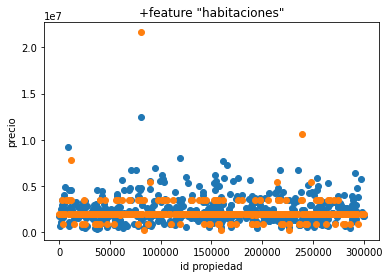

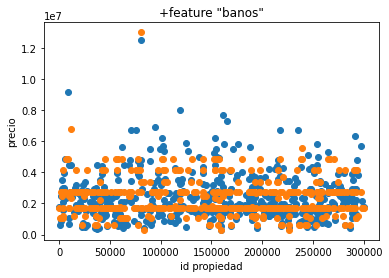

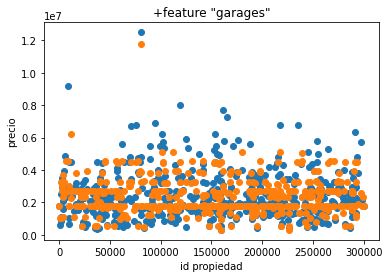

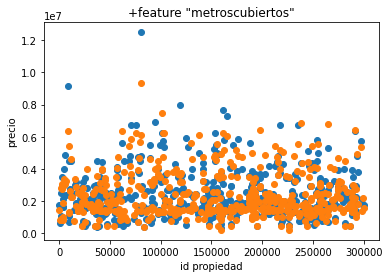

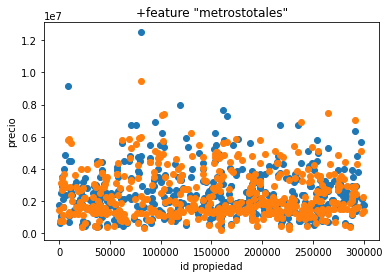

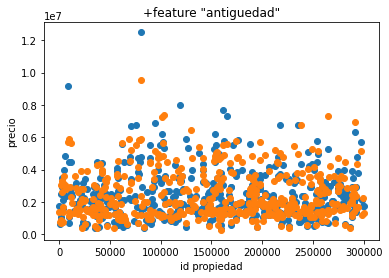

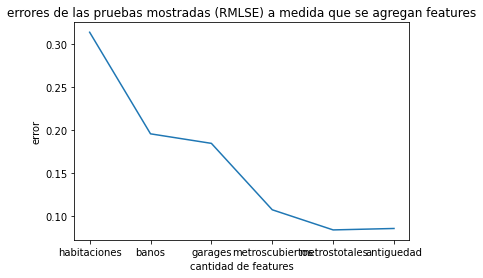

In [23]:
all_features_fns = {
    'habitaciones': np_x2,
    'banos': np_x2,
    'garages': np_x3,
    'metroscubiertos': np_x3,
    'metrostotales': np_x2,
    'antiguedad': np_x,
}

train_and_predict_suit(train_df, test_df, all_features_fns)

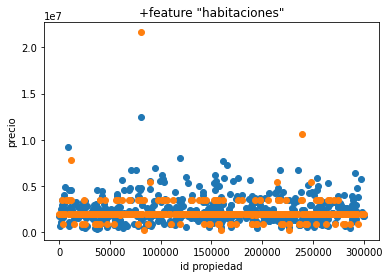

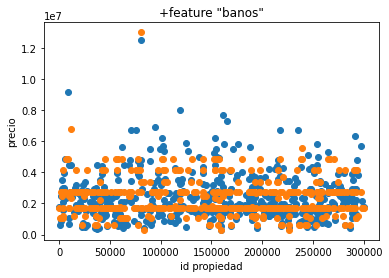

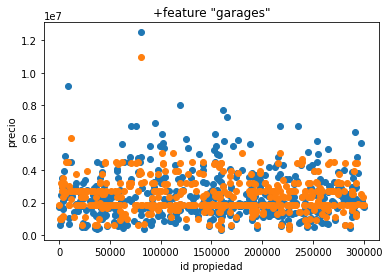

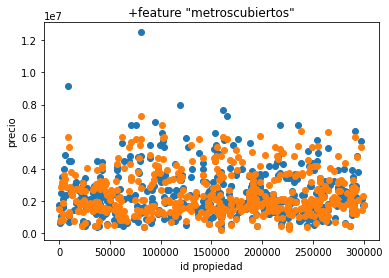

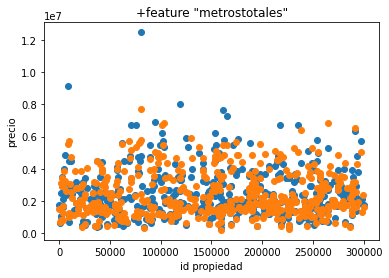

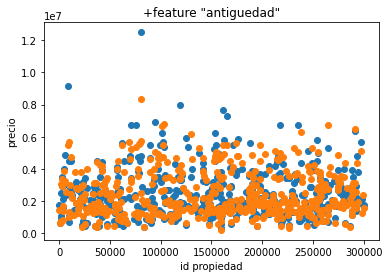

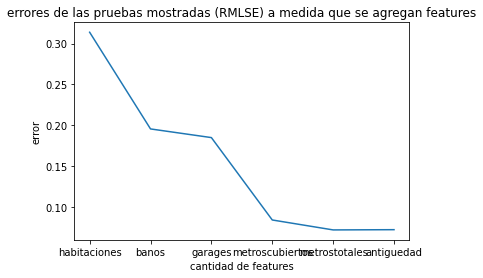

In [24]:
all_features_fns = {
    'habitaciones': np_x2,
    'banos': np_x2,
    'garages': np_x2,
    'metroscubiertos': np_x2,
    'metrostotales': np_x2,
    'antiguedad': np_x2,
}

train_and_predict_suit(train_df, test_df, all_features_fns)